In [94]:
import os
import sys
import subprocess
from pathlib import Path

repo_root = subprocess.run(
    ["git", "rev-parse", "--show-toplevel"], capture_output=True, text=True
).stdout.strip()

sys.path.append(repo_root)

In [95]:
import numpy as np

import torch
import torch.nn as nn
import torch.optim as optim
from torch.nn import functional as F

import pandas as pd
import pickle

from matplotlib import pyplot as plt

import params, utils
from modules import helpers, training
from modules.nn import mlp, pca

In [96]:
import importlib
importlib.reload(utils)

importlib.reload(training)

importlib.reload(mlp)
importlib.reload(pca)

<module 'modules.nn.pca' from '/Users/yongao/Desktop/8.13/mit-jlab-sp25/modules/nn/pca.py'>

In [97]:
helpers.set_plot_configs()

import warnings
warnings.filterwarnings("ignore", category=RuntimeWarning)

In [98]:
MC_dir = '../HiggsTo4L/MC/'
data_dir = '../HiggsTo4L/data/'

In [99]:
four_leptons_data = utils.FourLeptonsData()

print('Higgs:')
mc_higgs_all_data = four_leptons_data.apply_basic_cuts(
    [
        four_leptons_data.read_data(file) for file in [
            MC_dir + 'higgs2011.csv',
            MC_dir + 'higgs2012.csv'
        ]
    ],
    show_cut_info=True
)

print('ZZ:')
mc_zz_all_data = four_leptons_data.apply_basic_cuts(
    [ 
        four_leptons_data.read_data(file) for file in [
            MC_dir + 'zzto4mu2011.csv',
            MC_dir + 'zzto2mu2e2011.csv',
            MC_dir + 'zzto4e2011.csv',

            MC_dir + 'zzto4mu2012.csv',
            MC_dir + 'zzto2mu2e2012.csv',
            MC_dir + 'zzto4e2012.csv',
        ]
    ],
    show_cut_info=True
)

print('Drell-Yan:')
mc_dy_all_data = four_leptons_data.apply_basic_cuts(
    [
        four_leptons_data.read_data(file) for file in [
            MC_dir + 'dy1050_2011.csv',
            MC_dir + 'dy50_2011.csv',
            MC_dir + 'dy1050_2012.csv',
            MC_dir + 'dy50_2012.csv'
        ]
    ],
    show_cut_info=True
)

print('tt:')
mc_tt_all_data = four_leptons_data.apply_basic_cuts(
    [
        four_leptons_data.read_data(file) for file in [
            MC_dir + 'ttbar2011.csv',
            MC_dir + 'ttbar2012.csv'
        ]
    ],
    show_cut_info=True
)

Higgs:
 Conservation cut: 50542 events passed out of 52248 (97%)
 Leptons cut: 44320 events passed out of 50542 (88%)
 Z cut: 41818 events passed out of 44320 (94%)
 Conservation cut: 39353 events passed out of 40530 (97%)
 Leptons cut: 35855 events passed out of 39353 (91%)
 Z cut: 33996 events passed out of 35855 (95%)
ZZ:
 Conservation cut: 207439 events passed out of 209504 (99%)
 Leptons cut: 162016 events passed out of 207439 (78%)
 Z cut: 123286 events passed out of 162016 (76%)
 Conservation cut: 152367 events passed out of 155454 (98%)
 Leptons cut: 110224 events passed out of 152367 (72%)
 Z cut: 68099 events passed out of 110224 (62%)
 Conservation cut: 140811 events passed out of 144999 (97%)
 Leptons cut: 93161 events passed out of 140811 (66%)
 Z cut: 78064 events passed out of 93161 (84%)
 Conservation cut: 182153 events passed out of 183843 (99%)
 Leptons cut: 148678 events passed out of 182153 (82%)
 Z cut: 116017 events passed out of 148678 (78%)
 Conservation cut: 12

In [100]:
bins = np.linspace(50,200,101)
bin_centers = (bins[1:] + bins[:-1]) / 2
bin_width = bins[1] - bins[0]

higgs_hist = four_leptons_data.get_histogram(mc_higgs_all_data, params.scales_higgs, 'm4l', bins) 
zz_hist = four_leptons_data.get_histogram(mc_zz_all_data, params.scales_zz, 'm4l', bins)
dy_hist = four_leptons_data.get_histogram(mc_dy_all_data, params.scales_dy, 'm4l', bins)
tt_hist = four_leptons_data.get_histogram(mc_tt_all_data, params.scales_tt, 'm4l', bins)

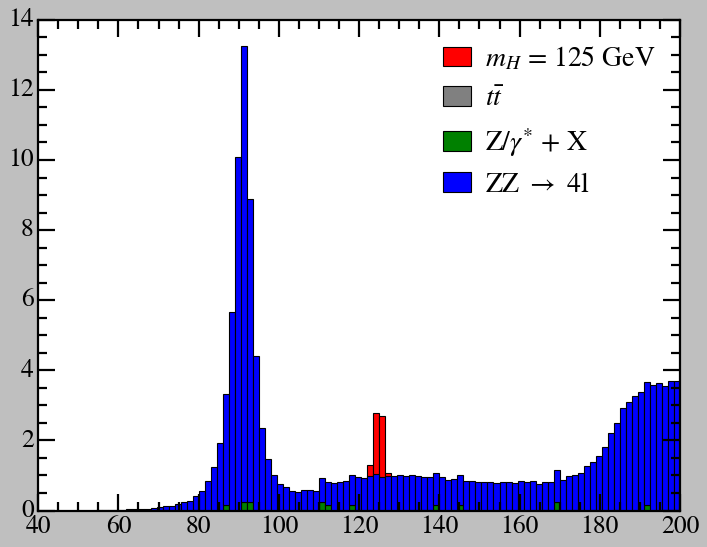

In [101]:
fig, ax = plt.subplots(figsize=(9,7))

stack = ax.bar(bin_centers, higgs_hist, align='center', width=bin_width, label=r'$m_{H}$ = 125 GeV', color='red')
stack = ax.bar(bin_centers, tt_hist, align='center', width=bin_width, label=r'$t\bar{t}$', color='grey')
stack = ax.bar(bin_centers, dy_hist, align='center', width=bin_width, label=r'Z/$\gamma^{*}$ + X', color='green', bottom=tt_hist)
stack = ax.bar(bin_centers, zz_hist, align='center', width=bin_width, label=r'ZZ $\rightarrow$ 4l', color='blue', bottom=tt_hist+dy_hist)

ax.legend(loc='upper right', frameon=False, ncol=1, handletextpad=0.5, handlelength=1.0, columnspacing=0.5)

plt.tight_layout()
plt.show()

In [102]:
class FourLeptonsPCA(pca.PCA):
    def __init__(self,
                 all_data,data_labels,
                 fields,field_indices):
        self.all_data = all_data
        self.event_nums = [len(data) for data in all_data]
        self.all_labels = [np.array([label]*len(data)) for label,data in zip(data_labels,all_data)]

        self.fields = fields
        self.field_indices = [field_indices[field] for field in fields]

    def _subsample(self, data, label, n):
        idx = np.random.choice(len(data), n, replace=False)
        return data[idx], label[idx]
    
    def get_pca(self):
        X = []
        Y = []

        for data,label in zip(self.all_data,self.all_labels):
            reduced_data, reduced_label = self._subsample(data,label,min(self.event_nums))
            X.append(reduced_data)
            Y.append(reduced_label)

        X = np.concatenate(X)
        Y = np.concatenate(Y)

        X = torch.from_numpy(X)

        X_norm, X_mean, X_std = self._standardize(X)
        X_pca, V = self._perform_pca(X_norm)

        return X_pca.numpy()[Y==1], X_pca.numpy()[Y==0]

In [103]:
mc_all_data = mc_higgs_all_data + mc_zz_all_data
fields = [
    'E1', 'px1', 'py1', 'pz1',
    'E2', 'px2', 'py2', 'pz2',
    'E3', 'px3', 'py3', 'pz3',
    'E4', 'px4', 'py4', 'pz4',
]

mc_all_pca = FourLeptonsPCA(all_data=mc_all_data,
                            data_labels=[1]*len(mc_higgs_all_data) + [0]*len(mc_zz_all_data),
                            fields=fields,
                            field_indices=params.field_indices)
higgs_pca, zz_pca = mc_all_pca.get_pca()

PC 1


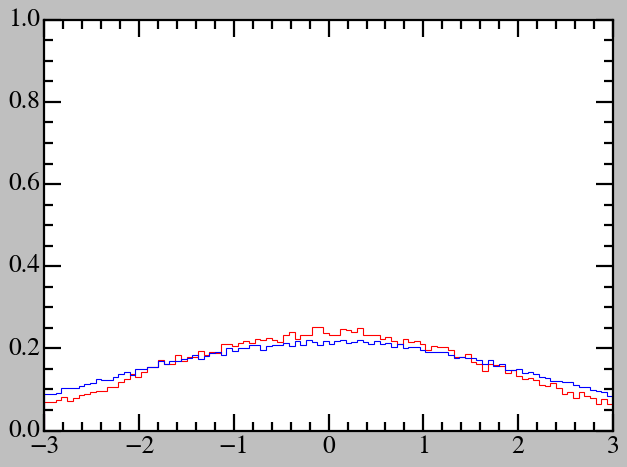

PC 2


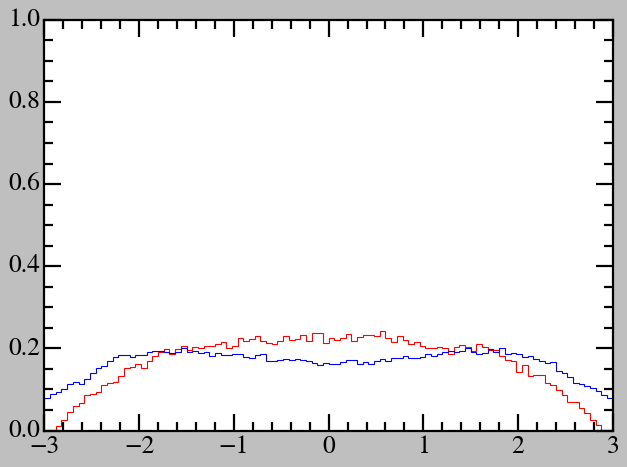

PC 3


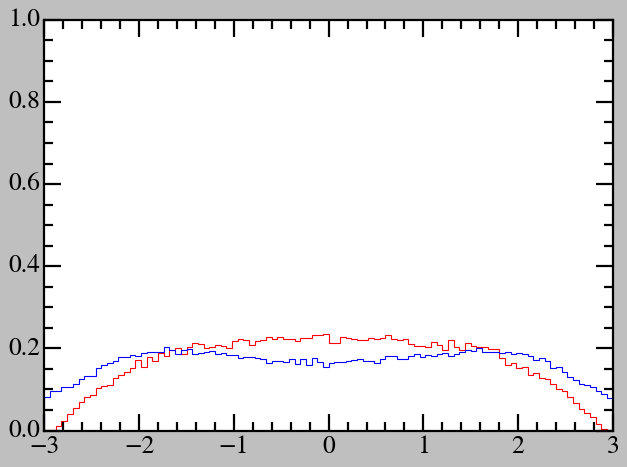

PC 4


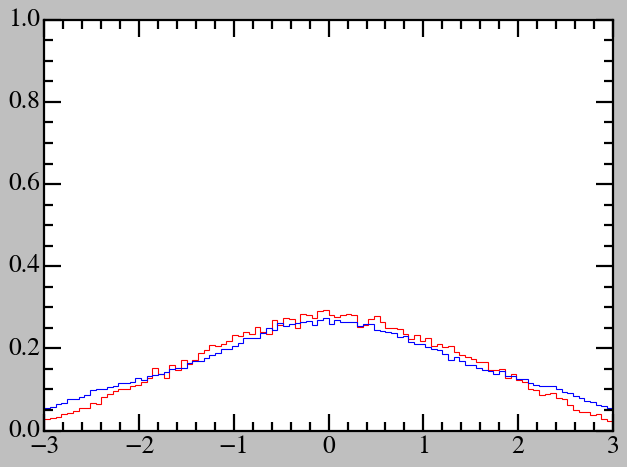

PC 5


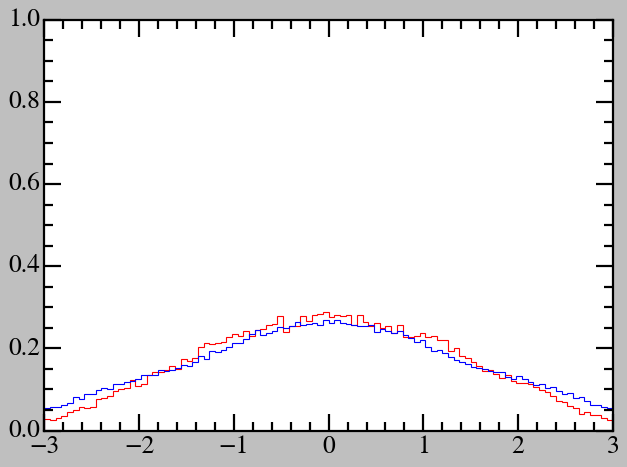

PC 6


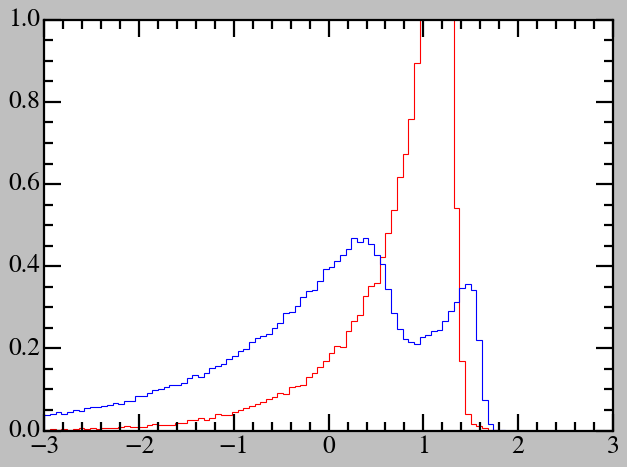

PC 7


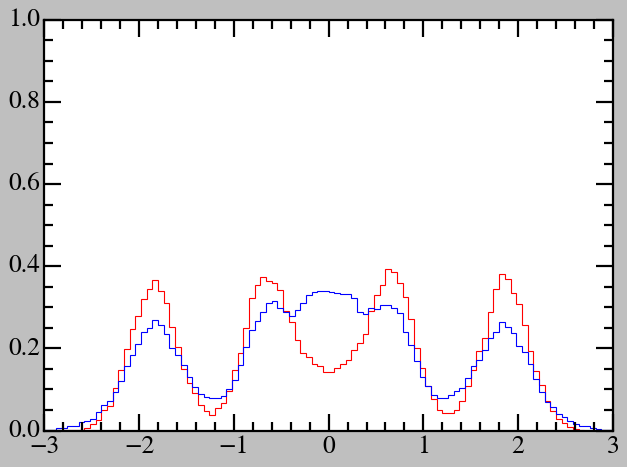

PC 8


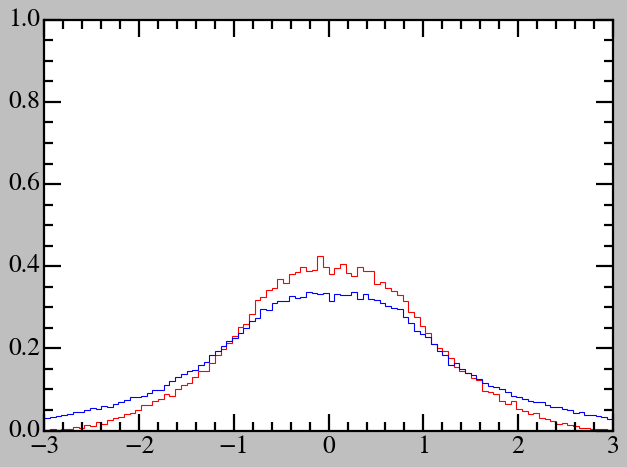

PC 9


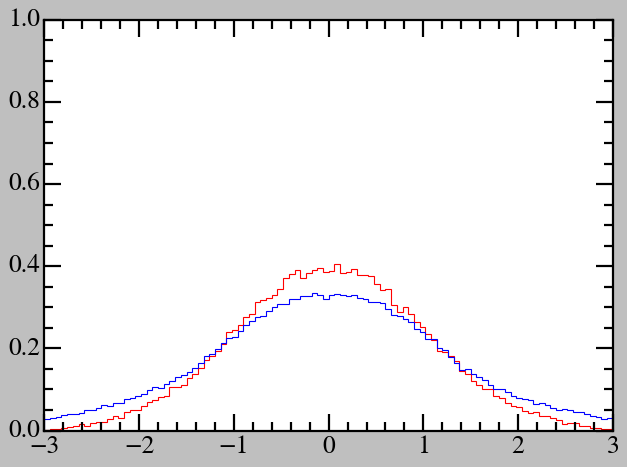

PC 10


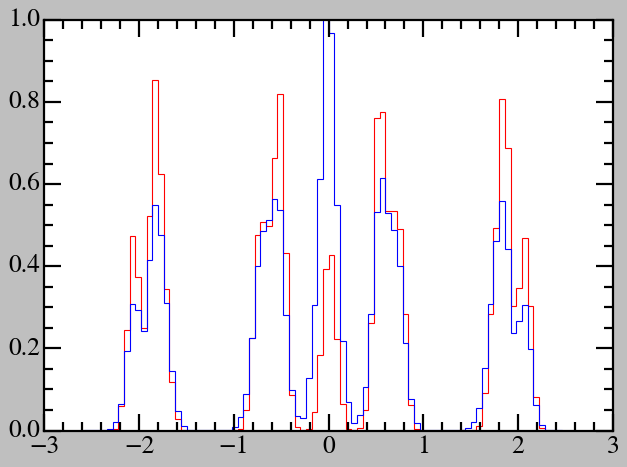

PC 11


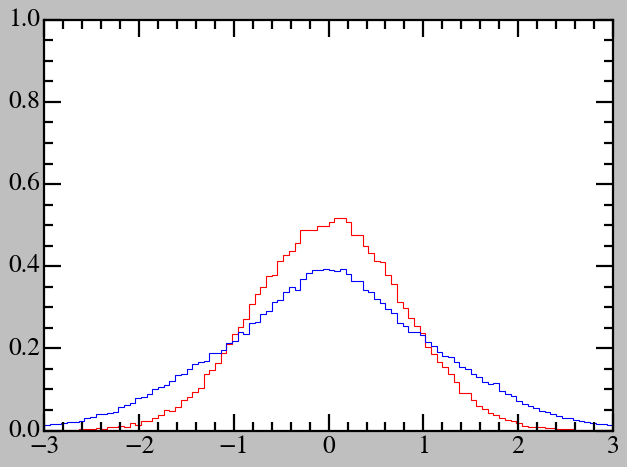

PC 12


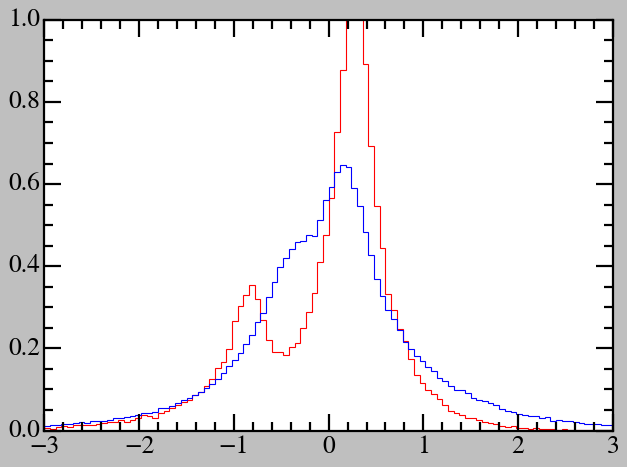

PC 13


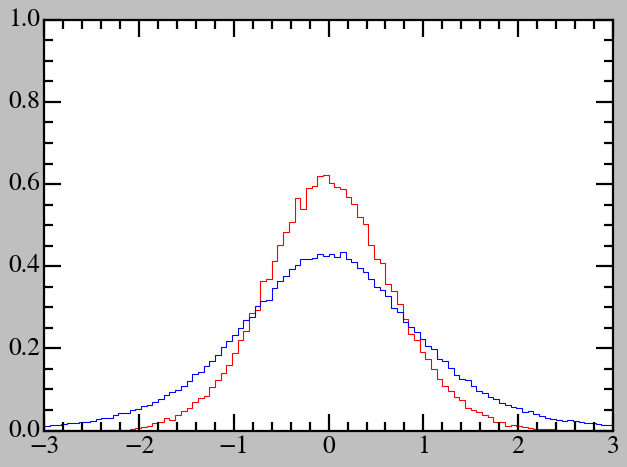

PC 14


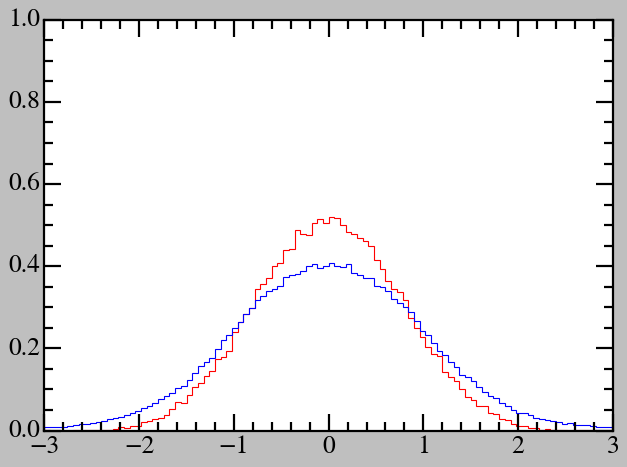

PC 15


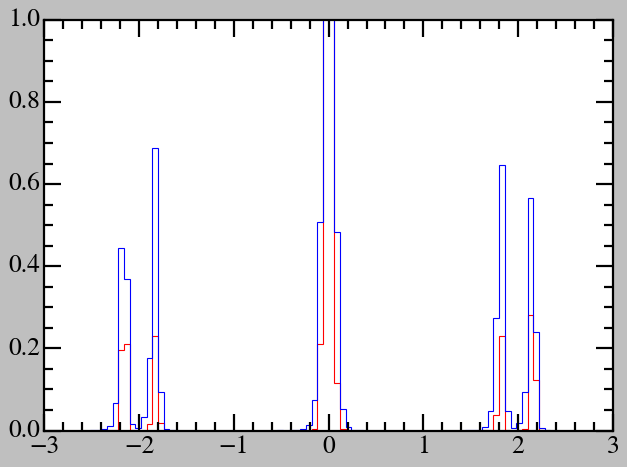

PC 16


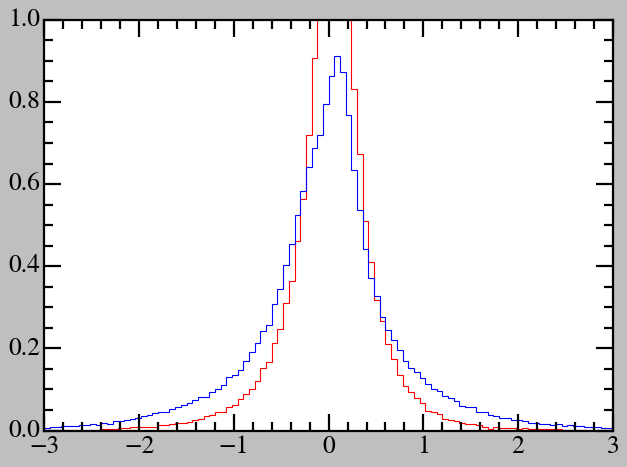

In [104]:
if True:
    for pca_idx in range(16):
        print('PC', pca_idx+1)

        bins = np.linspace(-3,3,101)
        bin_centers = (bins[1:] + bins[:-1]) / 2
        bin_width = bins[1] - bins[0]

        higgs_hist, _, _ = plt.hist(higgs_pca[:,pca_idx], bins=bins, histtype='step', color='red',density=True, lw=1)
        # plt.plot(bin_centers, np.cumsum(higgs_hist) * bin_width, color='red', lw=2, ls='--')

        zz_hist, _, _ = plt.hist(zz_pca[:,pca_idx], bins=bins, histtype='step', color='blue',density=True, lw=1)
        # plt.plot(bin_centers, np.cumsum(zz_hist) * bin_width, color='blue', lw=2, ls='--')

        plt.xlim(-3,3)
        plt.ylim(0,1)

        plt.tight_layout()
        plt.show()

In [105]:
def apply_pca_cut(data_list, pca_instance, threshold_values, pca_components_to_use):
    """
    Apply PCA-based cuts to each dataset while preserving luminosity info
    
    Parameters:
    data_list - list of datasets with potentially different luminosities
    pca_instance - fitted PCA instance
    threshold_values - list of (min, max) tuples for each PCA component
    pca_components_to_use - list of indices of PCA components to use for cuts
    
    Returns:
    List of filtered datasets with the same structure as the input
    """
    filtered_data_list = []
    total_events_before = 0
    total_events_after = 0
    
    for dataset in data_list:
        # Skip empty datasets
        if len(dataset) == 0:
            filtered_data_list.append(dataset)
            continue
            
        total_events_before += len(dataset)
        
        # Apply PCA transformation to this dataset
        dataset_pca = pca_instance.transform(dataset)
        
        # Initialize mask with all True
        mask = np.ones(len(dataset), dtype=bool)
        
        # Apply cuts for each selected PCA component
        for i, pca_idx in enumerate(pca_components_to_use):
            component_values = dataset_pca[:, pca_idx]
            min_val, max_val = threshold_values[i]
            # Update mask - only keep events that pass all cuts
            component_mask = (component_values >= min_val) & (component_values <= max_val)
            mask = mask & component_mask
        
        # Filter the dataset
        filtered_dataset = dataset[mask]
        filtered_data_list.append(filtered_dataset)
        total_events_after += len(filtered_dataset)
    
    print(f'Events after PCA cut: {total_events_after} of {total_events_before} ({total_events_after/total_events_before*100:.1f}%)')
    return filtered_data_list

<bound method PCA.fit of <modules.nn.pca.PCA object at 0x114d6a750>>
Events after PCA cut: 14733 of 516825 (2.9%)
Events after PCA cut: 727 of 75814 (1.0%)


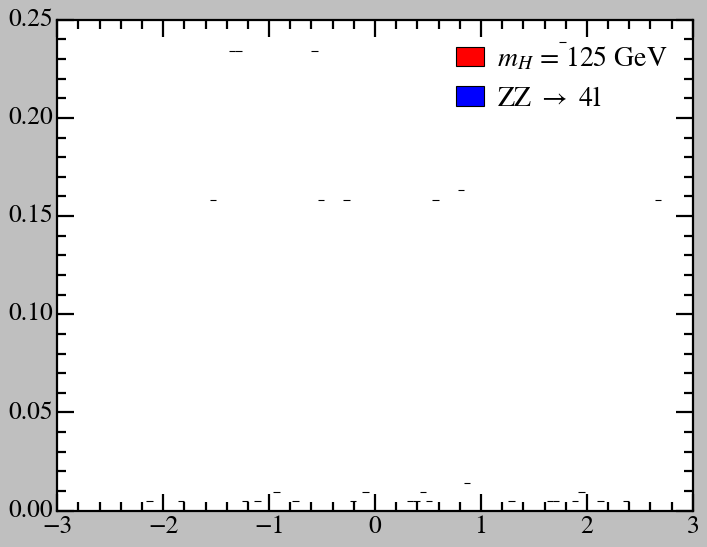

In [106]:
# First, add the methods to your PCA class
# Make sure your PCA is fitted to your training data
combined_data = np.concatenate([np.concatenate(mc_higgs_all_data), np.concatenate(mc_zz_all_data)])
pcaa = pca.PCA()
print(pcaa.fit)
pcaa.fit(combined_data)

# Define your PCA components and thresholds
pca_components_to_use = [5, 11]  # Using PC6 and PC12 (0-indexed)
threshold_values = [
    (0.6, 1.4),   # PC6 range
    (0, 0.7),     # PC12 range
]

# Apply to ZZ background data - maintaining separate datasets
mc_zz_filtered = apply_pca_cut(mc_zz_all_data, pcaa, threshold_values, pca_components_to_use)

# Apply to Higgs signal data - maintaining separate datasets
mc_higgs_filtered = apply_pca_cut(mc_higgs_all_data, pcaa, threshold_values, pca_components_to_use)

# Generate histograms using the filtered data while preserving luminosity scaling
higgs_hist = four_leptons_data.get_histogram(mc_higgs_filtered, params.scales_higgs, 'm4l', bins) 
zz_hist = four_leptons_data.get_histogram(mc_zz_filtered, params.scales_zz, 'm4l', bins)

fig, ax = plt.subplots(figsize=(9,7))

stack = ax.bar(bin_centers, higgs_hist, align='center', width=bin_width, label=r'$m_{H}$ = 125 GeV', color='red')
# stack = ax.bar(bin_centers, tt_hist, align='center', width=bin_width, label=r'$t\bar{t}$', color='grey')
# stack = ax.bar(bin_centers, dy_hist, align='center', width=bin_width, label=r'Z/$\gamma^{*}$ + X', color='green', bottom=tt_hist)
stack = ax.bar(bin_centers, zz_hist, align='center', width=bin_width, label=r'ZZ $\rightarrow$ 4l', color='blue', bottom=tt_hist+dy_hist)

ax.legend(loc='upper right', frameon=False, ncol=1, handletextpad=0.5, handlelength=1.0, columnspacing=0.5)

plt.tight_layout()
plt.show()

In [107]:
mc_dataset.N_data

NameError: name 'mc_dataset' is not defined

In [ ]:
model = mlp.MLP(
    input_dim=16,
    hidden_dims=[256, 64, 16, 4],
    output_dim=1,
    dropout=0.0,
    activation=nn.ReLU(),
    norm=nn.BatchNorm1d,
    last_activation=nn.Sigmoid(),
)

In [ ]:
trainer = training.SupervisedTraining(
    model=model,
    trainloader=mc_dataset.train_loader,
    valloader=mc_dataset.val_loader,
    num_epochs=150,
    lr=5e-4,
    criterion=nn.BCELoss(),
    optimizer=optim.Adam,
    scheduler=optim.lr_scheduler.CosineAnnealingLR,
    scheduler_params={'T_max': 50},
    is_classification=True,
    num_classes=2,
    device='mps',
)

In [ ]:
# trainer.train(save_training_stats_every=10, save_model_every=None, outpath='training_result/MLP/')

In [ ]:
training_stats = pickle.load(open('training_result/MLP/training_stats.pkl', 'rb'))

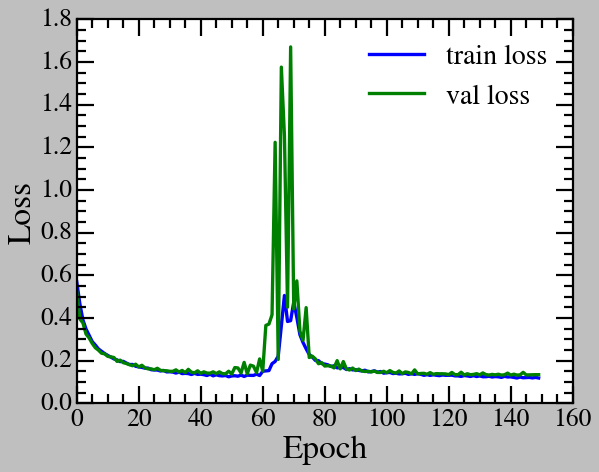

In [ ]:
plt.plot(training_stats['train_losses'], label='train loss')
plt.plot(training_stats['val_losses'], label='val loss')

plt.xlabel('Epoch')
plt.ylabel('Loss')

#plt.yscale('log')

plt.legend()
plt.show()

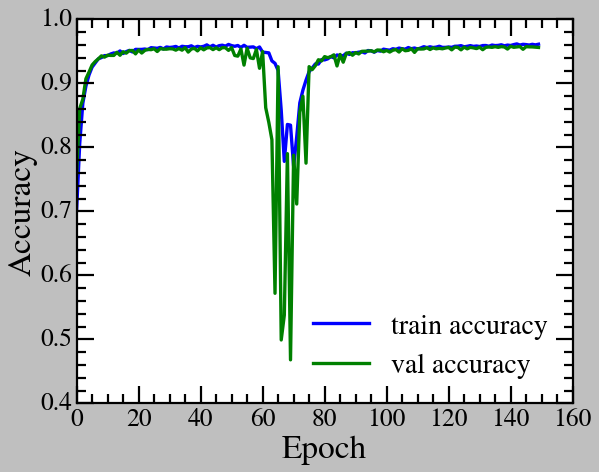

In [ ]:
plt.plot(training_stats['train_accuracies'], label='train accuracy')
plt.plot(training_stats['val_accuracies'], label='val accuracy')

plt.xlabel('Epoch')
plt.ylabel('Accuracy')

plt.legend()

plt.show()

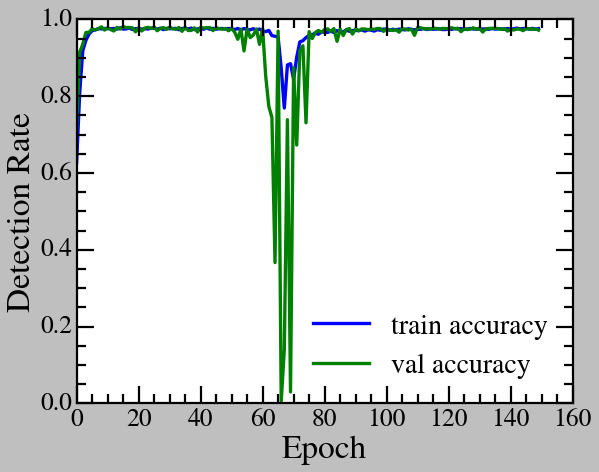

In [ ]:
plt.plot(training_stats['train_P_detections'], label='train accuracy')
plt.plot(training_stats['val_P_detections'], label='val accuracy')

plt.xlabel('Epoch')
plt.ylabel('Detection Rate')

plt.legend()

plt.show()

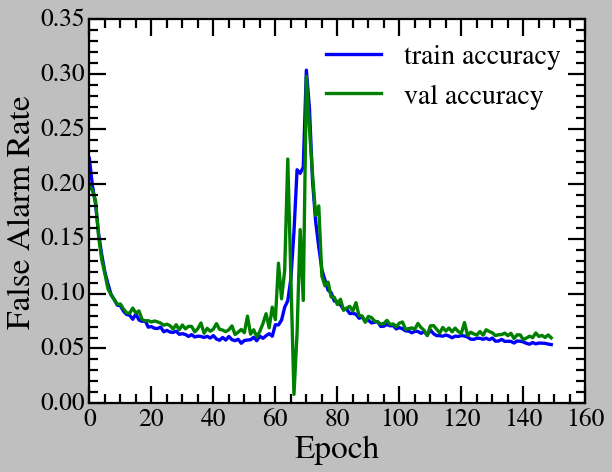

In [ ]:
plt.plot(training_stats['train_P_false_alarms'], label='train accuracy')
plt.plot(training_stats['val_P_false_alarms'], label='val accuracy')

plt.xlabel('Epoch')
plt.ylabel('False Alarm Rate')

plt.legend()

plt.show()